# Tutorial 2 - Decision Tree - Classification


We will predict the price category, among 4 categories, of an AIRBNB listing (`price_category` column). This is a multi-class classification task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          2
room_type                              0
accommodates                           0
bathrooms                             10
bedrooms                               8
beds                                   6
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 556
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                               2
beds                                   3
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 244
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [7]:
# We can't use the following columns in this tutorial, because they are not for binary classification tasks

train = train_set.drop(['price', 'price_gte_150'], axis=1) # axes 0 is row index and 1 is column
test = test_set.drop(['price', 'price_gte_150'], axis=1)


## Separate the target variable (we don't want to transform it)

In [8]:
train_y = train['price_category']
test_y = test['price_category']

train_inputs = train.drop(['price_category'], axis=1)
test_inputs = test.drop(['price_category'], axis=1)

## Feature Engineering: Let's derive a new column

#### Create a new binary column: if there is extra price per person, it is 1, otherwise, 0

In [9]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['extra_price'] = np.where(df1['price_per_extra_person'] > 0, 1, 0)
    
    return df1[['extra_price']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

In [10]:
#Let's test the new function:

# Send train set to the function we created
new_col(train_set)

,extra_price
1965,0
1450,0
2503,0
944,1
199,1
...,...
1130,1
1294,1
860,0
3507,1


##  Identify the numerical and categorical columns

In [11]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [12]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [13]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [14]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [15]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [16]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [17]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [18]:
feat_eng_columns = ['price_per_extra_person'] # this will be used in the transformation step in the pipeline

# Pipeline

In [19]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [20]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [21]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [22]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col))])

In [23]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [24]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.82254842,  0.69215829,  0.54753414, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.55146572,  0.15729058,  0.54753414, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07311286, -1.97951247, -0.59100739, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.61093878, -0.07631528,  3.96315871, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.17819153, -0.94575177, -1.16027815, ...,  0.        ,
         0.        ,  1.        ],
       [-0.33618088,  1.03587419, -0.59100739, ...,  0.        ,
         1.        ,  0.        ]])

In [25]:
train_x.shape

(2488, 67)

# Tranform: transform() for TEST

In [26]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[-1.21269719, -1.20324989,  0.54753414, ...,  0.        ,
         1.        ,  1.        ],
       [-2.86419979, -2.67831359, -0.59100739, ...,  0.        ,
         0.        ,  0.        ],
       [-0.11443035,  1.26295963, -0.59100739, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.47803436, -1.63486781, -0.59100739, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.59928397,  0.34795157,  2.82461719, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19953968,  0.22845713, -0.59100739, ...,  0.        ,
         1.        ,  0.        ]])

In [27]:
test_x.shape

(1067, 67)

# Baseline

In [28]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
#Baseline Train Accuracy
dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_y, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.3311897106109325


In [31]:
#Baseline Test Accuracy
dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_y, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.3402061855670103


# Decision Tree

Do NOT train a DecisionTreeClassifier() without any parameters. It OVERFITS. 

In [32]:
from sklearn.tree import DecisionTreeClassifier 

tree_clf = DecisionTreeClassifier(max_depth=5)

tree_clf.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=5)

## Accuracy

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
#Train accuracy:
train_y_pred = tree_clf.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.6036977491961415


In [35]:
#Test accuracy:
test_y_pred = tree_clf.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.5801312089971884


## Classification Matrix

In [36]:
from sklearn.metrics import confusion_matrix

#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[146,  40,  55,   4],
       [ 86, 160,  26,  91],
       [ 61,  12, 148,   0],
       [  7,  64,   2, 165]])

## Plot the Tree

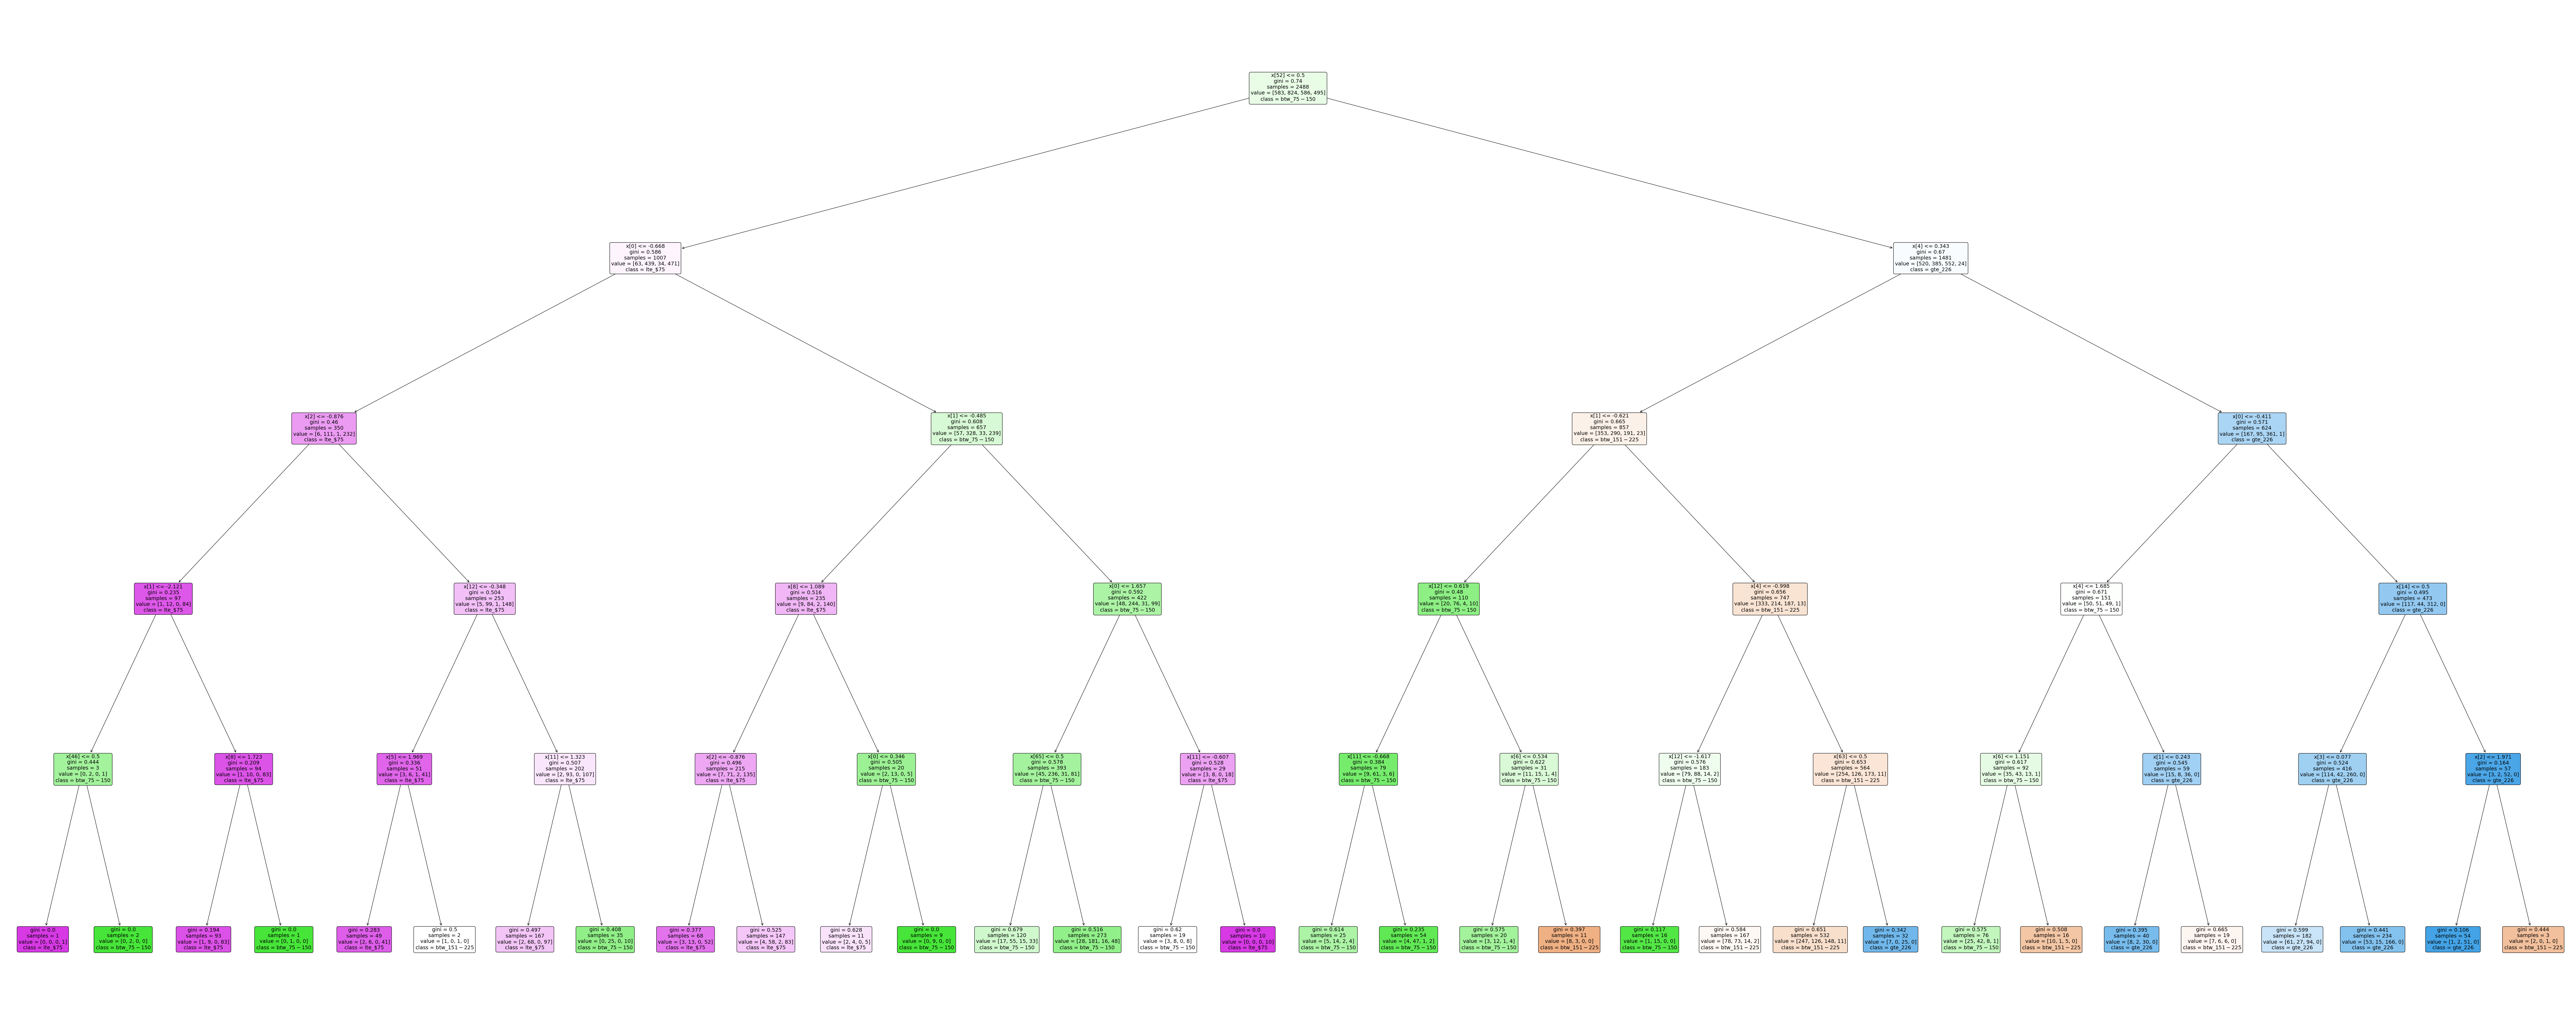

In [37]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))

tree = plot_tree(tree_clf, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=np.unique(train_y), 
              filled=True, 
              rounded=True, 
              fontsize=14)

## Feature Importance

In [38]:
# There are 65 columns, so there are 65 values for each column's importance
# Values are rounded to three decimals

np.round(tree_clf.feature_importances_,3)

array([0.107, 0.108, 0.029, 0.01 , 0.167, 0.004, 0.015, 0.   , 0.011,
       0.   , 0.   , 0.019, 0.03 , 0.   , 0.012, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.457, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.02 , 0.   , 0.008, 0.   ])

In [39]:
# The importance of the last column (i.e., the one we derived)

np.round(tree_clf.feature_importances_,3)[-1]

0.0

## More Regularization

In [40]:
tree_clf2 = DecisionTreeClassifier(min_samples_leaf = 10, max_depth=5)

tree_clf2.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

In [41]:
#Train accuracy:
train_y_pred = tree_clf2.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.6012861736334405


In [42]:
#Test accuracy:
test_y_pred = tree_clf2.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.5857544517338332


In [43]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[146,  40,  55,   4],
       [ 86, 165,  26,  86],
       [ 60,  12, 149,   0],
       [  7,  64,   2, 165]])

## Prediction probabilities

In [44]:
#Select a random observation

random = test_x[50:51]
random

array([[-0.85449093, -0.64236262, -0.02173662, -0.43231232, -0.32724017,
         0.42133671,  1.25362268, -0.40315781,  1.26658906, -0.14002161,
         2.9856231 ,  1.12556644,  0.55844268,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         1.        ,  1.        ]])

In [45]:
# Observe the input variables of the observation

tree_clf2.predict_proba(random)

array([[0.07407407, 0.87037037, 0.01851852, 0.03703704]])

In [46]:
# Round the probability values

np.round(tree_clf2.predict_proba(random),2)

array([[0.07, 0.87, 0.02, 0.04]])

## Change to entropy

In [47]:
tree_clf3 = DecisionTreeClassifier(max_depth=5, criterion='entropy')
tree_clf3.fit(train_x, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [48]:
#Train accuracy:
train_y_pred = tree_clf3.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.592443729903537


In [49]:
#Test accuracy:
test_y_pred = tree_clf3.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.5829428303655108


In [50]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[149,  36,  56,   4],
       [ 79, 158,  28,  98],
       [ 71,   9, 141,   0],
       [  4,  58,   2, 174]])

# Randomized Grid Search

Grid Search helps us try out a combination of different hyperparameters (sometimes randomly)

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {'max_depth': randint(low=5, high=20), 
              'min_samples_leaf': randint(low=5, high=20)}

tree_gs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, 
                             n_iter=15, cv=5, verbose=1,
                             scoring='accuracy',
                             return_train_score=True)

tree_gs.fit(train_x, train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=15,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9a88ec9a10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9a891baf10>},
                   return_train_score=True, scoring='accuracy', verbose=1)

In [52]:
cvres = tree_gs.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.5353696476045025 {'max_depth': 10, 'min_samples_leaf': 15}
0.5329567768054109 {'max_depth': 7, 'min_samples_leaf': 12}
0.5446203324363854 {'max_depth': 7, 'min_samples_leaf': 18}
0.5341551315927695 {'max_depth': 16, 'min_samples_leaf': 17}
0.5413897036839511 {'max_depth': 17, 'min_samples_leaf': 6}
0.5337535251670668 {'max_depth': 17, 'min_samples_leaf': 17}
0.5333632315984259 {'max_depth': 7, 'min_samples_leaf': 15}
0.5393832876778745 {'max_depth': 10, 'min_samples_leaf': 6}
0.5281172981665091 {'max_depth': 12, 'min_samples_leaf': 5}
0.5450082018213701 {'max_depth': 11, 'min_samples_leaf': 6}
0.5369760733073138 {'max_depth': 14, 'min_samples_leaf': 16}
0.5369720330012202 {'max_depth': 10, 'min_samples_leaf': 16}
0.5369728410624389 {'max_depth': 6, 'min_samples_leaf': 6}
0.5341551315927695 {'max_depth': 14, 'min_samples_leaf': 17}
0.5353777282166897 {'max_depth': 12, 'min_samples_leaf': 19}


In [53]:
#Find the best parameter set
tree_gs.best_params_

{'max_depth': 11, 'min_samples_leaf': 6}

In [54]:
tree_gs.best_estimator_

DecisionTreeClassifier(max_depth=11, min_samples_leaf=6)

In [55]:
#Train accuracy:
train_y_pred = tree_gs.best_estimator_.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.7411575562700965


In [56]:
#Test accuracy:
test_y_pred = tree_gs.best_estimator_.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.5801312089971884


In [57]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[114,  53,  76,   2],
       [ 56, 220,  28,  59],
       [ 51,  24, 146,   0],
       [ 12,  82,   5, 139]])